In [ ]:
#@title Set up the environment

!pip install -q git+https://github.com/google/jax-md.git
!pip install -q git+https://github.com/SSAGESLabs/PySAGES.git@jax-md

     |████████████████████████████████| 350 kB 12.4 MB/s 
     |████████████████████████████████| 90 kB 5.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 191 kB/s 


In [ ]:
#@title Imports & Utils

import numpy as onp

from jax.config import config ; config.update('jax_enable_x64', True)
import jax.numpy as np
from jax import random
from jax import jit
from jax import lax

import time

from jax_md import space
from jax_md import smap
from jax_md import energy
from jax_md import quantity
from jax_md import simulate
from jax_md import partition

import pysages
import pysages.backends as pb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
  
sns.set_style(style='white')

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Constant Energy Simulation With Neighbor Lists

Setup some system parameters.

In [ ]:
def generate_initial_positions(particles_per_side, spacing):
  R = onp.stack([onp.array(r) for r in onp.ndindex(*particles_per_side)]) * spacing
  return np.array(R, np.float64)

particles_per_side = (200, 200)
spacing = np.float32(1.25)
side_length = np.asarray(particles_per_side) * spacing

R = generate_initial_positions(particles_per_side, spacing)

In [ ]:
#@title Draw the initial state
ms = 5
R_plt = onp.array(R)

plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms * 0.5)

plt.xlim([0, np.max(R[:, 0])])
plt.ylim([0, np.max(R[:, 1])])

plt.axis('off')

finalize_plot((2, 2))

In [ ]:
# format = partition.Dense
# format = partition.Sparse
format = partition.OrderedSparse

In [ ]:
dt = 1e-3

In [ ]:
def generate_context(particles_per_side=particles_per_side, spacing=spacing, format=format, dt=dt):
  # Define the simulation space
  side_length = np.asarray(particles_per_side) * spacing
  displacement, shift = space.periodic(side_length, wrapped=False)
  R = generate_initial_positions(particles_per_side, spacing)
  
  # Define the energy function (we will use a neighbor list for this example)
  neighbor_fn, energy_fn = energy.lennard_jones_neighbor_list(
    displacement, side_length, format=format
  )
  
  # Allocate the neighbors list
  nbrs = neighbor_fn.allocate(R)
  
  # Set up the simulation
  _init_fn, apply_fn = simulate.nve(energy_fn, shift, dt)

  def init_fn(seed=0):
    state = _init_fn(random.PRNGKey(seed), R, kT=1e-3, neighbor=nbrs)
    return pb.JaxMDContextState(state, dict(nbrs=nbrs))

  def step_fn(context_state):
    state = context_state.state
    nbrs = context_state.extras["nbrs"]
    nbrs = nbrs.update(state.position)
    state = apply_fn(state, neighbor=nbrs)
    return pb.JaxMDContextState(state, dict(nbrs=nbrs))

  return pb.JaxMDContext(init_fn, step_fn, side_length, dt)

In [ ]:
# Reference index for our Collective Variable
j = onp.prod(particles_per_side) // 2
# Set the list of collective variables
collective_variables = [pysages.colvars.Distance([j, j + 1])]
# Sampling method and its parameters
grid = pysages.Grid(lower=2.0, upper=50.0, shape=64)
restraints = pysages.CVRestraints(lower=2.0, upper=50.0, kl=0, ku=0.1)
method = pysages.methods.ABF(collective_variables, grid, restraints=restraints)

In [ ]:
raw_result = pysages.run(method, generate_context, int(1e5))

/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32. In future JAX releases this will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/pysages/methods/abf.py:212: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  Wp = linalg.solve(Jxi @ Jxi.T, Jxi @ p, sym_pos="sym")


In [ ]:
result = pysages.analyze(raw_result)

/usr/local/lib/python3.7/dist-packages/pysages/ml/utils.py:54: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  data, structure = tree_flatten(params)
/usr/local/lib/python3.7/dist-packages/pysages/ml/optimizers.py:212: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  dp = solve(H, Je, sym_pos=True)
/usr/local/lib/python3.7/dist-packages/pysages/ml/optimizers.py:212: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  dp = solve(H, Je, sym_pos=True)


In [ ]:
free_energy = result["free_energy"]

In [ ]:
side_length

DeviceArray([250., 250.], dtype=float32)

In [ ]:
from jax import vmap

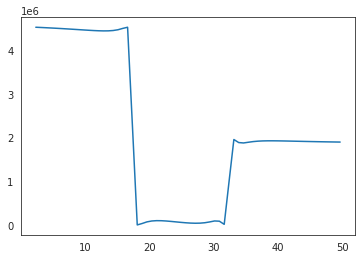

In [ ]:
plt.plot(result["mesh"], result["free_energy"])